In [1]:
import json
from itertools import product
import typing
import glob

import numpy as np
import pandas as pd
from lmfit.models import ExpressionModel
import matplotlib.pyplot as plt
import altair as alt
from altair import datum

In [2]:
filename = "Data/Ne photoelectron density - TDCASSCF - Filelist.xlsx"
weight = pd.read_excel(filename, "Weights", index_col="Ang (rad)")["Weight"]

In [3]:
def read(filename: str) -> pd.DataFrame:
    with open(filename, "r") as fp:
        data = json.load(fp)

    d = data["Data"][0]
    q = np.array(d["Mag q num"]["Values"])
    r = np.array(d["Momentum (au)"]["Values"])
    theta = np.array(d["Polar ang (rad)"]["Values"])
    idx = pd.MultiIndex.from_product([q, theta],
                                     names=["Mag q num", "Polar ang (rad)"])

    eps = np.finfo(np.float16).eps
    if not (theta - weight.index < eps).all():
        raise ValueError("Invalid table!")

    rho = np.array(d["Density"]["Values"])
    at = (rho * weight[None, None, :]).sum((0, 2)).argmax()

    def gen() -> typing.Iterator[dict]:
        for d in data["Data"]:
            if not ((np.array(d["Mag q num"]["Values"]) == q).all()
                    and (np.array(d["Momentum (au)"]["Values"]) == r).all()
                    and (np.array(d["Polar ang (rad)"]["Values"]) == theta).all()):
                raise ValueError("Invalid table!")

            arr = np.array(d["Density"]["Values"])[:, at, :]
            for (i, j), k in zip(product(q, theta), arr.reshape(-1)):
                if i < 0:
                    continue
                yield {"Group": data["Group"],
                       "Photon energy (eV)": d["Photon energy (eV)"],
                       "Opt phase (deg)": d["Opt phase (deg)"],
                       "Config": f"m={i}",
                       "Polar ang (rad)": j,
                       "Density": k}
            for j, k in zip(theta, arr.sum(0)):
                yield {"Group": data["Group"],
                       "Photon energy (eV)": d["Photon energy (eV)"],
                       "Opt phase (deg)": d["Opt phase (deg)"],
                       "Config": "sum[m]",
                       "Polar ang (rad)": j,
                       "Density": k}
    return pd.DataFrame(list(gen()))

In [4]:
patt = "Data/Ne photoelectron density - TDCASSCF - G*.json"
expanded = pd.concat((read(fn) for fn in glob.iglob(patt)), ignore_index=False)
expanded.head()

,Config,Density,Group,Opt phase (deg),Photon energy (eV),Polar ang (rad)
0,m=0,0.021030,G1654,0,16.54,3.141593
1,m=0,0.018642,G1654,0,16.54,2.978504
2,m=0,0.013869,G1654,0,16.54,2.842989
3,m=0,0.008362,G1654,0,16.54,2.708580
4,m=0,0.003758,G1654,0,16.54,2.574496


In [5]:
def fit(df: pd.DataFrame) -> pd.DataFrame:
    where = df["Polar ang (rad)"] < 0.5 * np.pi
    theta = df["Polar ang (rad)"][where].mean()
    x = df["Opt phase (deg)"] / 180 * np.pi
    x[~where] = x[~where] + np.pi
    y = df["Density"]

    model = ExpressionModel("amp * cos(x - shift) + offset")
    model.set_param_hint("amp", value=y.std(), min=0)
    model.set_param_hint("shift", value=x[y.idxmax()])
    model.set_param_hint("offset", value=y.mean())
    result = model.fit(y, x=x)
    
    idx = pd.Index([theta, np.pi - theta], name="Polar ang (rad)")
    amp = result.params["amp"].value
    if amp == 0:
        return pd.DataFrame({"Amp": amp,
                             "Phase shift (rad)": pd.Series([np.nan, np.nan], index=idx)})
    dph = 0.5 * np.pi
    shift = (result.params["shift"].value + dph) % (2 * np.pi) - dph
    return pd.DataFrame({"Amp": amp,
                         "Phase shift (rad)": pd.Series([shift, shift + np.pi], index=idx)})


def norm_phase(df: pd.DataFrame) -> pd.DataFrame:
    where = ~df["Phase shift (rad)"].isna()
    df.loc[where, "Phase shift (rad)"] = np.unwrap(df.loc[where, "Phase shift (rad)"])
    return df


def norm_amp(df: pd.DataFrame) -> pd.DataFrame:
    split = df.reset_index([0, 1, 3], drop=True)
    r = split.loc["m=0", "Amp"] + 2 * split.loc["m=1", "Amp"]
    split["Rel amp"] = split["Amp"] / r
    return split


expanded["Polar ang (idx)"] = (90 - expanded["Polar ang (rad)"] / np.pi * 180).abs().round()
fitted = (
    expanded
    .groupby(["Group", "Photon energy (eV)", "Config", "Polar ang (idx)"])
    .apply(fit)
    .reset_index(level=3, drop=True)
    .sort_index()  # Sort by polar angles
    .groupby(["Group", "Photon energy (eV)", "Config"])
    .apply(norm_phase)
    .groupby(["Group", "Photon energy (eV)", "Polar ang (rad)"])
    .apply(norm_amp)
)
fitted.head()

# filename = "Data/Ne phase shift diffs - TDCASSCF - From PADs.csv"
# fitted.reset_index().to_csv(filename, index=False)

Amp  Phase shift (rad)  \
Group Photon energy (eV) Polar ang (rad) Config                                
G1430 14.3               0.000000        m=0     0.003255           1.033615   
                                         m=1     0.000000                NaN   
                                         sum[m]  0.003255           1.033615   
                         0.163088        m=0     0.002694           1.042097   
                                         m=1     0.000231           1.224096   

                                                  Rel amp  
Group Photon energy (eV) Polar ang (rad) Config            
G1430 14.3               0.000000        m=0     1.000000  
                                         m=1     0.000000  
                                         sum[m]  1.000000  
                         0.163088        m=0     0.853356  
                                         m=1     0.073322

In [2]:
inten = pd.read_excel("Data/Ne photoelectron density - TDCASSCF - Filelist.xlsx", sheet_name="Groups")
inten["Amp0"] = inten["1H intensity (W/cm2)"] * inten["2H intensity (W/cm2)"] ** 0.5

fitted = (
    pd
    .read_excel("Data/Ne phase shift diffs.xlsx", sheet_name="TDCASSCF")
    .merge(inten[["Group", "Amp0"]], on="Group")
    .set_index(["Group", "Photon energy (eV)", "Config", "Polar ang (rad)"])
)
fitted["Norm amp"] = fitted["Amp"] / fitted["Amp0"] * 1e20
fitted.head()

Method   KE (eV)  \
Group Photon energy (eV) Config Polar ang (rad)                        
G1430 14.3               m=0    0.000000         TD-CASSCF  4.012611   
                         m=1    0.000000         TD-CASSCF  4.012611   
                         sum[m] 0.000000         TD-CASSCF  4.012611   
                         m=0    0.163088         TD-CASSCF  4.012611   
                         m=1    0.163088         TD-CASSCF  4.012611   

                                                 Polar ang (deg)       Amp  \
Group Photon energy (eV) Config Polar ang (rad)                              
G1430 14.3               m=0    0.000000                0.000000  0.003255   
                         m=1    0.000000                0.000000  0.000000   
                         sum[m] 0.000000                0.000000  0.003255   
                         m=0    0.163088                9.344254  0.002694   
                         m=1    0.163088                9.344254  0.000231   

                                                  Rel amp  Phase shift (rad)  \
Group Photon energy (eV) Config Polar ang (rad)                                
G1430 14.3               m=0    0.000000         1.000000           1.033615   
                         m=1    0.000000         0.000000                NaN   
                         sum[m] 0.000000         1.000000           1.033615   
                         m=0    0.163088         0.853356           1.042097   
                         m=1    0.163088         0.073322           1.224096   

                                                 Phase shift (deg)  \
Group Photon energy (eV) Config Polar ang (rad)                      
G1430 14.3               m=0    0.000000                 59.221805   
                         m=1    0.000000                       NaN   
                         sum[m] 0.000000                 59.221805   
                         m=0    0.163088                 59.707750   
                         m=1    0.163088                 70.135533   

                                                 Rel phase shift (rad)  \
Group Photon energy (eV) Config Polar ang (rad)                          
G1430 14.3               m=0    0.000000                      0.000000   
                         m=1    0.000000                           NaN   
                         sum[m] 0.000000                      0.000000   
                         m=0    0.163088                     -0.026600   
                         m=1    0.163088                      0.155399   

                                                 Rel phase shift adjacent  \
Group Photon energy (eV) Config Polar ang (rad)                             
G1430 14.3               m=0    0.000000                         1.000000   
                         m=1    0.000000                              NaN   
                         sum[m] 0.000000                         1.000000   
                         m=0    0.163088                         0.999646   
                         m=1    0.163088                         0.987950   

                                                         Amp0  Norm amp  
Group Photon energy (eV) Config Polar ang (rad)                          
G1430 14.3               m=0    0.000000         1.523155e+17  2.137320  
                         m=1    0.000000         1.523155e+17  0.000000  
                         sum[m] 0.000000         1.523155e+17  2.137320  
                         m=0    0.163088         1.523155e+17  1.768752  
                         m=1    0.163088         1.523155e+17  0.151975

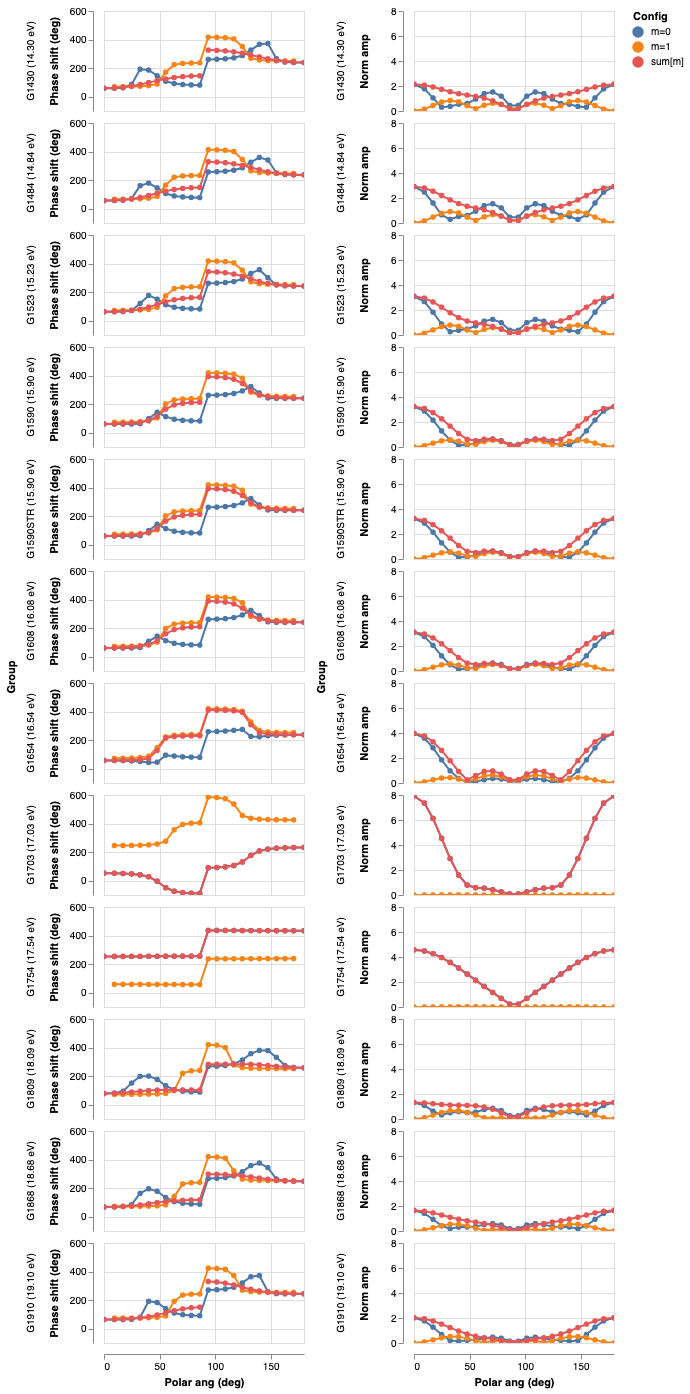

In [3]:
df = fitted.reset_index()
df["Group"] = df.apply(lambda c: "{} ({:.2f} eV)".format(c["Group"], c["Photon energy (eV)"]), axis=1)

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Polar ang (deg):Q",
        y="Phase shift (deg):Q",
        color="Config:N",
        )
    .facet(row="Group:N")
    | base
    .encode(
        x="Polar ang (deg):Q",
        y="Norm amp:Q",
        color="Config:N",
        )
    .facet(row="Group:N")
)

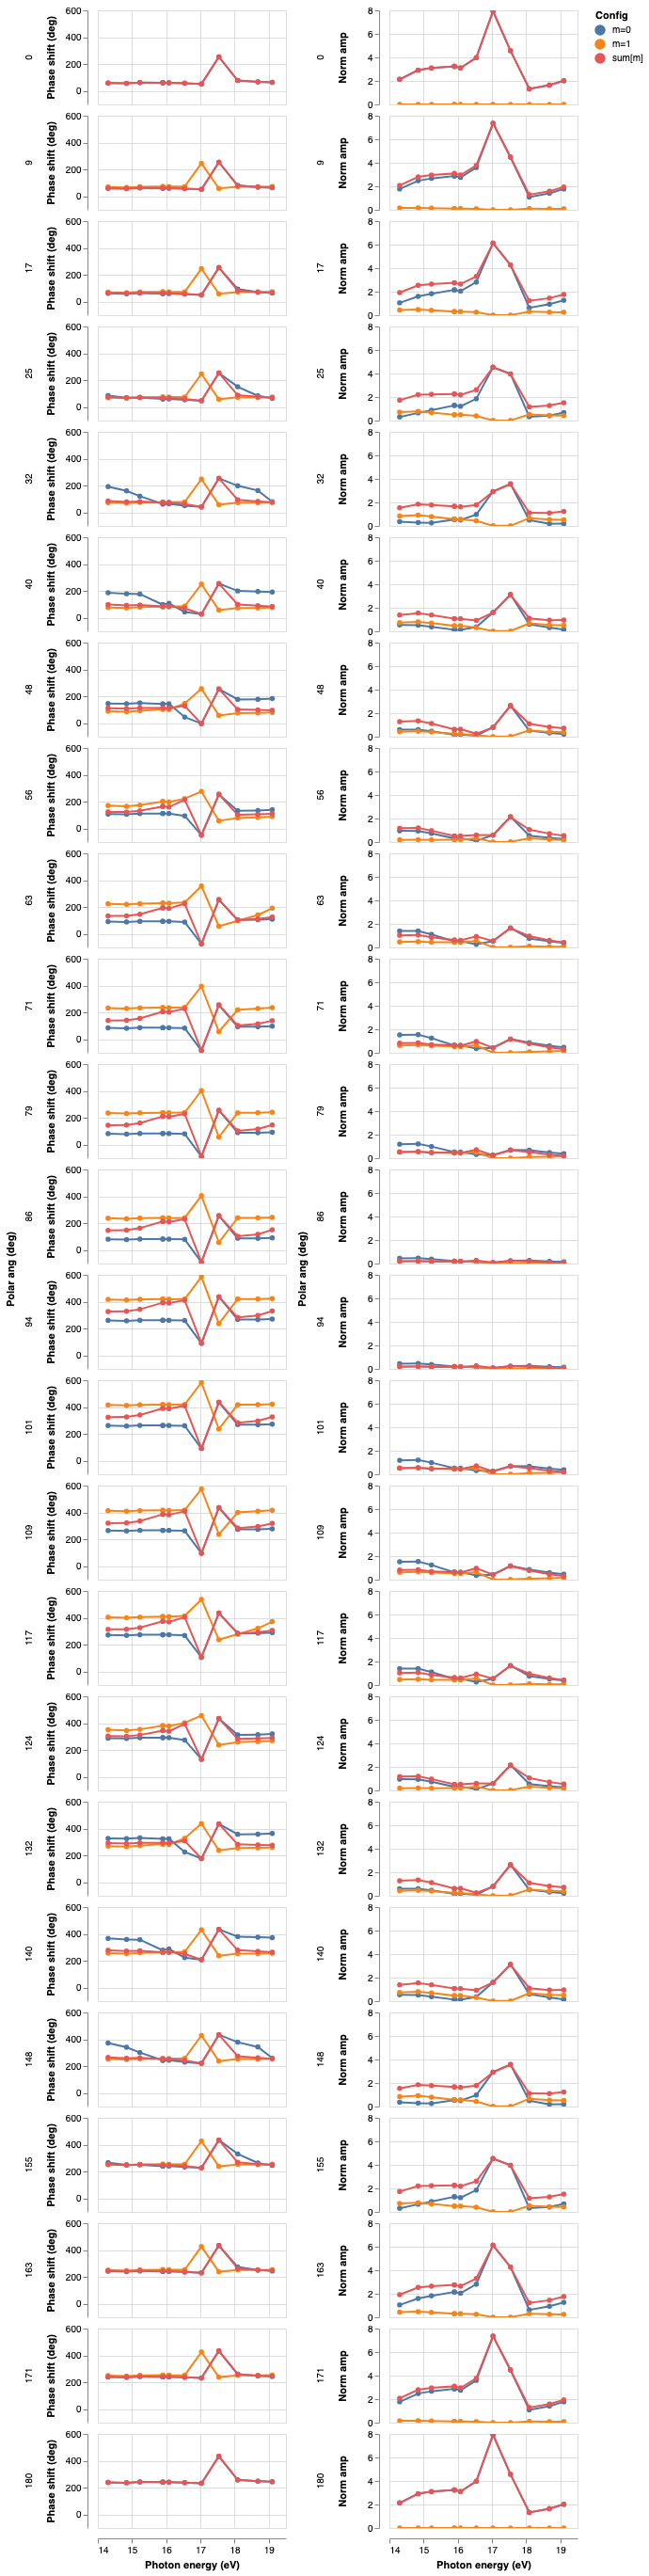

In [5]:
df = fitted.reset_index()
df["Polar ang (deg)"] = df["Polar ang (deg)"].round()
df = df[df["Polar ang (deg)"] != 90]

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Photon energy (eV)",
        y="Phase shift (deg)",
        color="Config",
        )
    .facet(row="Polar ang (deg)")
    | base
    .encode(
        x="Photon energy (eV)",
        y="Norm amp",
        color="Config",
        )
    .facet(row="Polar ang (deg)")
)